In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

from os import listdir
from os.path import isfile, join
import json

import cv2
import itertools
import pickle
import seaborn as sns
import tensorflow.keras.losses as ls
import os

from albumentations import CenterCrop, GridDistortion, HorizontalFlip, RandomRotate90, VerticalFlip
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

TRAIN_IMAGES_PATH = '/content/drive/MyDrive/BIG DATA 2/Small Train'
MASKS_PATH = '/content/drive/MyDrive/BIG DATA 2/masks'

In [3]:
def getMASKfromJSON(json):
    smallMask = json['mask']
    mask = np.zeros((512,512),dtype='float32')
    for y in range(len(smallMask)):
        for x in range(len(smallMask[0])):
            if x >= 512:
              mask[json['minY']+y,0] = smallMask[y][x]
            elif y >= 512:
              mask[0,json['minX']+x] = smallMask[y][x]
            else:
              mask[json['minY']+y,json['minX']+x] = smallMask[y][x]
    return(mask)
    

In [4]:
imageFiles = [f for f in listdir(TRAIN_IMAGES_PATH) if isfile(join(TRAIN_IMAGES_PATH, f))]
print(len(imageFiles),"training images.")
images = []
for f in tqdm(imageFiles,total=len(imageFiles)):
  im = cv2.imread(join(TRAIN_IMAGES_PATH,f),cv2.IMREAD_COLOR)
  images.append(cv2.resize(im,(IMG_WIDTH,IMG_HEIGHT)))
masks = []
for f in tqdm(imageFiles,total=len(imageFiles)):
  f = open(join(MASKS_PATH,f[:-3]+'out'))
  json_load = json.load(f)
  m = getMASKfromJSON(json_load)
  masks.append(cv2.resize(m,(IMG_WIDTH,IMG_HEIGHT)).astype(int)) 
train_df = pd.DataFrame({"img":images,"seg":masks})

1750 training images.


100%|██████████| 1750/1750 [00:14<00:00, 121.81it/s]


In [5]:
def normalize_images(image):
  return (image / 127.5 -1)

def image_padding(im):
  h, w = im.shape[0], im.shape[1]
  new_size = max([h, w])
  if len(im.shape)==3:
    pad = np.zeros([new_size, new_size, 3])
    pad[abs(h-new_size)//2: abs(h-new_size)//2 + h, abs(w-new_size)//2: abs(w-new_size)//2 + w, :] = im
  else:
    pad = np.zeros([new_size, new_size])
    pad[abs(h-new_size)//2: abs(h-new_size)//2 + h, abs(w-new_size)//2: abs(w-new_size)//2 + w] = im
  return pad

def resize_xy(df_xy, size=256, pad=False):
  # resize segmentation masks and image while keeping the label values
  orig_shape = []
  img_resized = []
  seg_resized = []
  for i in range(len(df_xy)):
    orig_shape.append(df_xy.loc[i,'img'].shape)
    if pad:
      # pad images before resizing to not distort the proportions
      img = image_padding(df_xy.loc[i,'img'])
      msk = image_padding(df_xy.loc[i,'seg'])
    else:
      img = df_xy.loc[i,'img']
      msk = df_xy.loc[i,'seg']
    img_resized.append(normalize_images(cv2.resize(img, (size, size))))
    seg_resized.append(cv2.resize(msk, (size, size), 0, 0, interpolation = cv2.INTER_NEAREST).astype('float'))
  df_xy['orig_shape'] = orig_shape
  df_xy['img_resized'] = img_resized
  df_xy['seg_resized'] = seg_resized
  return df_xy

def augment_data(imgs, masks, size=512):
  H = size
  W = size
  aug_imgs = []
  aug_masks = []
  for i in range(len(imgs)):
    x = imgs[i]
    y = masks[i]

    aug = CenterCrop(H, W, p=1.0)
    augmented = aug(image=x, mask=y)
    x1 = augmented["image"]
    y1 = augmented["mask"]

    aug = RandomRotate90(p=1.0)
    augmented = aug(image=x, mask=y)
    x2 = augmented['image']
    y2 = augmented['mask']

    aug = GridDistortion(p=1.0)
    augmented = aug(image=x, mask=y)
    x3 = augmented['image']
    y3 = augmented['mask']

    aug = HorizontalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    x4 = augmented['image']
    y4 = augmented['mask']

    aug = VerticalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    x5 = augmented['image']
    y5 = augmented['mask']

    aug_imgs.append([x, x1, x2, x3, x4, x5])
    aug_masks.append([y, y1, y2, y3, y4, y5])
  return aug_imgs, aug_masks

In [6]:
def convolution_block(block_input, num_filters=64, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear")(x)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)
    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [7]:
model = DeeplabV3Plus(image_size=128, num_classes=2)
model.load_weights('/content/drive/MyDrive/BIG DATA 2/MODELTHATWORKS.h5')

In [8]:
def remove_padding(im, dims):
  new_size = im.shape[0]
  return im[abs(dims[0]-new_size)//2: abs(dims[0]-new_size)//2 + dims[0], abs(dims[1]-new_size)//2: abs(dims[1]-new_size)//2 + dims[1]]

def infer(model, dataset_df, remove_pad=False):
  # this function predicts the image segmentation masks and resize them to the original image size
  predictions = []
  for i in range(len(dataset_df)):
    im = dataset_df.loc[i, 'img_resized']
    dims = dataset_df.loc[i, 'orig_shape']
    pred = model.predict(np.expand_dims(im, 0))
    pred = np.squeeze(pred)
    # resize predicitons to original shape
    if remove_pad:
      # if padding was used, that needs to be removed after resizing to the original dimensions
      s = max([dims[1], dims[0]])
      pred = cv2.resize(np.argmax(pred, axis=2), (s, s), 0, 0, interpolation = cv2.INTER_NEAREST)
      predictions.append(remove_padding(pred, dims))
    else:
      pred = cv2.resize(np.argmax(pred, axis=2), (dims[1], dims[0]), 0, 0, interpolation = cv2.INTER_NEAREST)
      predictions.append(pred)
  dataset_df['prediction'] = predictions
  return dataset_df

In [9]:
def plot_segmentation_results(ind, data_df, is_training_set = True):
  cl = {0: 'background', 1:'pool', 2:'bicycle', 3:'bird', 4:'boat', 5:'bottle', 6:'bus', 7:'car', 8:'cat', 9:'chair', 10:'cow',
        11:'diningtable', 12:'dog', 13:'horse', 14:'motorbike', 15:'person', 16:'pottedplant', 17:'sheep', 18:'sofa', 19:'train', 20:'tvmonitor'}
  sns.set_style('white')
  plt.figure(figsize=(20,15))
  if is_training_set:
    plt.subplot(131)
    plt.imshow(data_df.loc[ind, 'img'].astype('uint8'))
    plt.title('Original image', fontsize=15)
    plt.subplot(132)
    plt.imshow(data_df.loc[ind, 'seg'])
    true_lab = [cl[l] for l in np.unique(data_df.loc[ind, 'seg']) if l!=0]
    plt.title(' '.join(['True labels:'] + true_lab), fontsize=15)
    plt.subplot(133)
    plt.imshow(data_df.loc[ind, 'prediction'])
    pred_lab = [cl[l] for l in np.unique(data_df.loc[ind, 'prediction']) if l!=0]
    plt.title(' '.join(['Predicted:'] + pred_lab), fontsize=15)
  # in case of test set, we don't have the true labels so we just display the original image and the segmentation result
  else:
    plt.subplot(121)
    plt.imshow(data_df.loc[ind, 'img'].astype('uint8'))
    plt.title('Original image', fontsize=15)
    plt.subplot(122)
    plt.imshow(data_df.loc[ind, 'seg'])
    pred_lab = [cl[l] for l in np.unique(data_df.loc[ind, 'seg']) if l!=0]
    plt.title(' '.join(['Predicted:'] + pred_lab), fontsize=15)

In [10]:
training_set = resize_xy(train_df, 128)
training_set = infer(model, training_set)


In [25]:
def get1s(mask):
    c = 0
    for i in range(len(mask)):
        for j in range(len(mask[0])):
            if mask[i,j] == 1:
                c += 1
    return c

def get0s(mask):
    c = 0
    for i in range(len(mask)):
        for j in range(len(mask[0])):
            if mask[i,j] == 0:
                c += 1
    return c

def getRealAccuracy(realMask, predictedMask):
    True1 = 0
    True0 = 0
    False1 = 0
    False0 = 0    

    ones = get1s(realMask)
    zeroes = get0s(realMask)

    for i in range(len(realMask)):
        for j in range(len(realMask[0])):
            if realMask[i,j] == 1 and predictedMask[i,j] == 1:
                True1 += 1
            if realMask[i,j] == 0 and predictedMask[i,j] == 0:
                True0 += 1
            if realMask[i,j] == 0 and predictedMask[i,j] == 1:
                False1 += 1
            if realMask[i,j] == 1 and predictedMask[i,j] == 0:
                False0 += 1  

            T1 = True1/ones
            T0 = True0/zeroes
            F1 = False1/zeroes
            F0 = False0/ones

    return {'True1':T1,'True0':T0,'False1':F1,'False0':F0}

In [29]:
from tqdm import tqdm

T0 = []
T1 = []
sumT0 = 0
sumT1 = 0
for i in tqdm(range(len(training_set))):
  r = getRealAccuracy(training_set['seg'][0],training_set['prediction'][0])
  T0.append(r['True0'])
  T1.append(r['True1'])
  sumT0 += r['True0']
  sumT1 += r['True1']

print("T1: ",sumT1/len(training_set))
print("T0: ",sumT0/len(training_set))

100%|██████████| 1750/1750 [44:01<00:00,  1.51s/it]

T1:  0.9453213077790537
T0:  0.9975304374543691


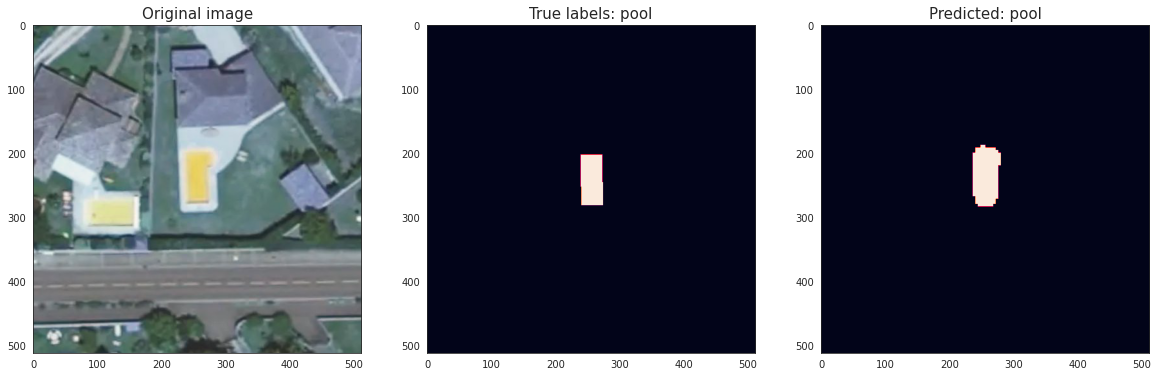

In [12]:
plot_segmentation_results(6, training_set)